In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%cd /content/drive/MyDrive/tp

/content/drive/MyDrive/tp


In [2]:
from m6bk import *

In [3]:
dataset_handler = DatasetHandler()

# Environment Perception For Self-Driving Cars


**Dans cette tâche, vous devrez :**

- Utiliser la sortie des réseaux neuronaux de segmentation sémantique pour estimer l'espace praticable en 3D.
- Utiliser la sortie des réseaux neuronaux de segmentation sémantique pour estimer les voies de circulation.
- Utiliser la sortie de la segmentation sémantique pour filtrer les erreurs dans la sortie des détecteurs d'objets 2D.
- Utiliser les résultats de détection d'objets 2D filtrés pour déterminer la distance à laquelle se trouvent les obstacles par rapport à la voiture autonome.

Pour la plupart des exercices, une structure suggérée vous est fournie. Vous êtes encouragé à vous écarter de cette structure si vous pensez qu'il existe une meilleure façon, plus efficace, de résoudre un problème.

Veuillez suivre les cellules dans l'ordre. Les cellules inférieures dépendront des cellules supérieures pour fonctionner correctement.

Vous n'êtes autorisé à utiliser que les packages chargés ci-dessous, principalement numpy, OpenCV et les fonctions personnalisées expliquées dans le notebook. Exécutez la cellule ci-dessous pour importer les packages requis :




In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m6bk import *
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(precision=2, threshold=sys.maxsize)

## 0 - Loading and Visualizing the Data
 
Nous vous fournissons une classe dataset handler pratique pour lire et itérer à travers des échantillons provenant du simulateur CARLA. 

Exécutez le code suivant pour créer un objet dataset handler 

In [5]:
dataset_handler = DatasetHandler()


le gestionnaire de jeux de données contient trois frames  de données de test : 0, 1 et 2. Chaque frame contient :

**DatasetHandler().rgb** : une image RVB de la caméra

**DatasetHandler().depth** : une image de profondeur contenant la profondeur en mètres pour chaque pixel.

**DatasetHandler().segmentation**: une image contenant la sortie d'un réseau neuronal de segmentation sémantique sous forme de catégorie par pixel.

**DatasetHandler().object_detection**: un tableau numpy contenant la sortie d'un réseau de détection d'objets.
La frame 0 sera utilisée tout au long de ce tp comme exemple en cours d'exécution. **La frame 1 sera utilisée pour la soumission et l'évaluation de cette évaluation** . La frame 2 est fournie comme défi pour les apprenants intéressés par un exemple plus difficile.

la frame de données actuellement lue peut être connue grâce à la ligne de code suivante :

In [6]:
dataset_handler.current_frame

0

Lors de la création de l'objet gestionnaire de jeux de données, la trame 0 est automatiquement lue et chargée. Le contenu de la trame peut être accédé en utilisant quatre attributs différents de l'objet gestionnaire de jeux de données : **image, depth, object_detection et semantic segmentation**. 

Par exemple, pour accéder à l'image, à la matrice de calibration de la caméra et à la profondeur, exécutez les trois cellules suivantes :

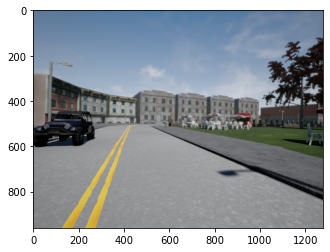

In [7]:
image = dataset_handler.image
plt.imshow(image)

In [8]:
k = dataset_handler.k
print(k)

[[640   0 640]
 [  0 640 480]
 [  0   0   1]]


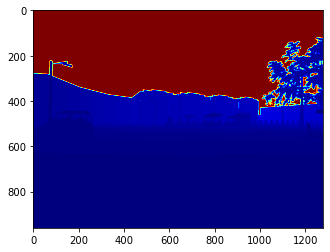

In [9]:
depth = dataset_handler.depth
plt.imshow(depth, cmap='jet')

La sortie de la segmentation sémantique peut être accédée de manière similaire à travers :

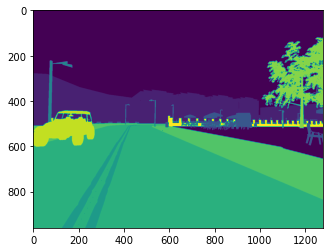

In [10]:
segmentation = dataset_handler.segmentation
plt.imshow(segmentation)

### Mappings des catégories de segmentation :
L'image de segmentation de sortie contient des indices de mappage de chaque pixel à une catégorie de scène routière. Pour visualiser la sortie de segmentation sémantique, nous effectuons la correspondance des indices de mappage avec différentes couleurs. Les indices de mappage et les couleurs de visualisation pour chaque catégorie de scène routière peuvent être trouvés dans le tableau suivant :

|Catégorie	|Indice de mappage	|Couleur de visualisation|
| --- | --- | --- |
|Arrière-plan|	0	| Noir |
|Bâtiments|	1	| Rouge |
|Piétons|	4 |	Sarcelle |
|Poteaux|	5 |	Blanc |
|Marquages de voie|	6 |	Violet |
|Routes|	7 |	Bleu |
|Trottoirs|	8 |	Jaune |
|Véhicules|	10| 	Vert |




La fonction **vis_segmentation** du gestionnaire de jeux de données transforme l'image d'indice en une image couleur pour la visualisation :

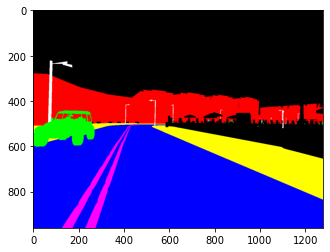

In [11]:
colored_segmentation = dataset_handler.vis_segmentation(segmentation)

plt.imshow(colored_segmentation)

La fonction **set_frame** prend en entrée un numéro de trame de 0 à 2 et charge cette trame ainsi que toutes ses données associées. Elle sera utile pour les tests et la soumission à la fin de cette évaluation.

In [12]:
dataset_handler.set_frame(2)
dataset_handler.current_frame

2

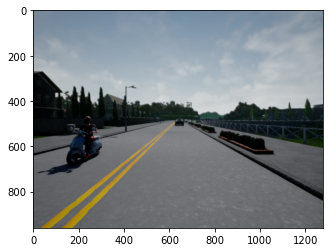

In [13]:
image = dataset_handler.image
plt.imshow(image)

## 1 - Estimation de l'espace praticable en utilisant la sortie de la segmentation sémantique



Votre première tâche consiste à implémenter l'estimation de l'espace praticable en 3D. Vous disposez de la sortie d'un réseau neuronal de segmentation sémantique, de la matrice de calibration de la caméra K, ainsi que de la profondeur par pixel.

### 1.1 - Estimation des coordonnées x, y et z de chaque pixel dans l'image :

Pour calculer les coordonnées x, y et z de chaque pixel de l'image en utilisant la matrice de calibration de la caméra et les informations de profondeur, vous pouvez utiliser les équations suivantes :

$$z = depth $$

$$x = \frac{(u - c_u) * z}{f} \tag{1}$$

$$y = \frac{(v - c_v) * z}{f} \tag{2}$$

Ici, $c_u$, $c_v$ et $f$ sont les paramètres de calibration intrinsèque trouvés dans la matrice de calibration de la caméra K de la manière suivante :

$$K = \begin{pmatrix} f & 0 & u_c \\ 0 & f & u_v \\ 0& 0 & 1 \end{pmatrix}$$

***Note***: Assurez-vous d'être sur la trame 0 pour le reste de cette évaluation. Vous utiliserez les autres trames pour les tests une fois l'évaluation terminée.

**Exercise**: Mettez en œuvre l'estimation des coordonnées x et y de chaque pixel en utilisant les équations (1) et (2) :

In [36]:
# GRADED FUNCTION: xy_from_depth
# GRADED FUNCTION: xy_from_depth
def xy_from_depth(depth, k):
    """
    Calcule les coordonnées x et y de chaque pixel dans l'image en utilisant la carte de profondeur et la matrice de calibration.

    Arguments :

    depth : tenseur de dimension (H, W), contient une valeur de profondeur (en mètres) pour chaque pixel de l'image.
    k : tenseur de dimension (3x3), la matrice de caméra intrinsèque.
    Renvoie :

    x : tenseur de dimension (H, W) contenant les coordonnées x de chaque pixel dans le repère de la caméra.
    y : tenseur de dimension (H, W) contenant les coordonnées y de chaque pixel dans le repère de la caméra.
    """
    ### START CODE HERE ### (≈ 7 lines in total)

    # Obtenir le shape du tenseur de profondeur
    print(depth.shape)
    
    # Extraire les paramètres requis de la matrice K
    cu = k[0][2]
    cv = k[1][2]
    f = k[0][0]
    
    print(cu,cv)
    # Générer une grille de coordonnées correspondant à la forme de la carte de profondeur
    x=np.zeros(depth.shape)
    y=np.zeros(depth.shape)
    
    # Calculer les coordonnées x et y
    for u in range(depth.shape[0]):
        for v in range(depth.shape[1]):
            x[u][v] = depth[u][v] * (u-cu)/f 
            y[u][v] = depth[u][v] * (v-cv)/f 
    
    ### END CODE HERE ###
    
    return x, y

In [37]:
dataset_handler.set_frame(0)

k = dataset_handler.k

z = dataset_handler.depth

x, y = xy_from_depth(z, k)

print('x[800,800] = ' + str(x[800, 800]))
print('y[800,800] = ' + str(y[800, 800]))
print('z[800,800] = ' + str(z[800, 800]) + '\n')

print('x[500,500] = ' + str(x[500, 500]))
print('y[500,500] = ' + str(y[500, 500]))
print('z[500,500] = ' + str(z[500, 500]) + '\n')

(960, 1280)
640 480
x[800,800] = 0.716
y[800,800] = 1.432
z[800,800] = 2.864

x[500,500] = -9.64315625
y[500,500] = 1.37759375
z[500,500] = 44.083



**Expected Output**:

$x[800,800] = 0.720$
<br />
$y[800,800] = 1.436$
<br />
$z[800,800] = 2.864$

$x[500,500] = -9.5742765625$
<br />
$y[500,500] = 1.4464734375$
<br />
$z[500,500] = 44.083$

### 1.2 - Estimation du plan de sol à l'aide de RANSAC :

Dans le contexte des voitures autonomes, l'espace praticable comprend tout espace que la voiture est physiquement capable de parcourir en 3D. La tâche d'estimation de l'espace praticable consiste à estimer les pixels appartenant au plan du sol dans la scène. Pour l'exercice suivant, vous utiliserez RANSAC pour estimer le plan du sol dans le référentiel de coordonnées de la caméra 3D à partir des coordonnées x, y et z estimées précédemment.

La première étape consiste à traiter la sortie de la segmentation sémantique pour extraire les pixels pertinents appartenant à la classe que vous souhaitez considérer comme le sol. Pour cette évaluation, cette classe est la classe de la route avec un indice de mappage de 7. Pour extraire les coordonnées x, y et z de la route, exécutez la cellule suivante :

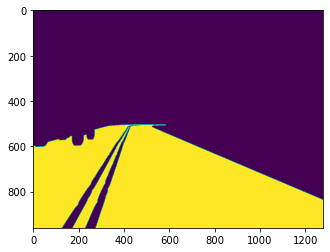

In [75]:
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1

# Show road mask
plt.imshow(road_mask)

# Get x,y, and z coordinates of pixels in road mask
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = dataset_handler.depth[road_mask == 1]

xyz_ground = np.stack((x_ground, y_ground, z_ground))

# xyz_data = xyz_ground
# p1,p2,p3 = 0,200,300
# p1 = [xyz_data[0][p1],xyz_data[1][p1],xyz_data[2][p1]]
# p2 = [xyz_data[0][p2],xyz_data[1][p2],xyz_data[2][p2]]
# p3 = [xyz_data[0][p3],xyz_data[1][p3],xyz_data[2][p3]]
# print(np.array(([[p1[0],p2[0],p3[0]],[p1[1],p2[1],p3[1]],[p1[2],p2[2],p3[2]]])).shape)

# print(xyz_ground[:][0]) doesnt work ( a lot of data for some reason )

# print(xyz_ground[0][0],xyz_ground[1][0],xyz_ground[2][0])

The next step is to use the extracted x, y, and z coordinates of pixels belonging to the road to estimate the ground plane. RANSAC will be used for robustness against outliers.

**Exercise**:
Implémentez RANSAC pour l'estimation d'un plan. Voici les 6 étapes :
1. Choisissez au hasard un minimum de 3 points dans xyz_ground.
2. Calculez le modèle du plan du sol en utilisant les points aléatoires choisis et la fonction fournie compute_plane.
3. Calculez la distance du modèle du plan du sol à chaque point dans xyz_ground, et comptez le nombre de points inclus en fonction d'un seuil de distance.
4. Vérifiez si le nombre actuel de points inclus est supérieur à toutes les itérations précédentes et conservez l'ensemble des points inclus avec le plus grand nombre de points.
5. Répétez jusqu'à ce que le nombre d'itérations soit supérieur ou égal à un nombre prédéfini d'itérations, ou que le nombre de points inclus soit supérieur ou égal au nombre minimum de points inclus.
6. Recalculez et retournez un modèle de plan en utilisant tous les points inclus dans l'ensemble final de points inclus.






Fonctions utiles: `np.random.choice()`, `compute_plane()`, `dist_to_plane()`.

Les deux fonctions personnalisées suivantes sont fournies pour vous aider à terminer cette partie 

1. ***compute_plane(xyz):***
```
    Calcule les coefficients du plan a, b, c, d de la forme ax+by+cz+d = 0

    Arguments :
    xyz -- tenseur de dimension (3, N), contenant les points nécessaires pour ajuster le plan.
    k -- tenseur de dimension (3x3), la matrice intrinsèque de la caméra.

    Retourne :
    p -- tenseur de dimension (1, 4) contenant les paramètres du plan a, b, c, d

```

2. ***dist_to_plane(plane, x, y, z):***

```
   Calcule la distance de N points à un plan en 3D, étant donné les paramètres du plan et les coordonnées x, y, z des points.

    Arguments :
    plane -- tenseur de dimension (4,1), contenant les paramètres du plan [a, b, c, d]
    x -- tenseur de dimension (Nx1), contenant les coordonnées x des points
    y -- tenseur de dimension (Nx1), contenant les coordonnées y des points
    z -- tenseur de dimension (Nx1), contenant les coordonnées z des points

    Retourne :
    distance -- tenseur de dimension (N, 1) contenant la distance entre les points et le plan

```
Les fonctions sont déjà chargées grâce à l'instruction d'importation au début du notebook. Vous pouvez également réaliser vous-même l'estimation du plan si vous êtes prêt à relever le défi !

In [107]:
def ransac_plane_fit(xyz_data):
    """
    Calcule les coefficients du plan a, b, c, d de la forme ax+by+cz+d = 0
        en utilisant RANSAC pour le rejet des valeurs aberrantes.

    Arguments :
    xyz_data -- tenseur de dimension (3, N), contenant toutes les données à partir desquelles l'échantillonnage aléatoire sera effectué.
    num_itr -- 
    distance_threshold -- Seuil de distance par rapport au plan pour qu'un point soit considéré comme un inlier.

    Retourne :
    p -- tenseur de dimension (1, 4) contenant les paramètres du plan a, b, c, d
    """
    
    ### START CODE HERE ### (≈ 23 lines in total)
    
    nb_points = xyz_data.shape[1]
    print(nb_points)
    
    # Set thresholds:
    num_itr = 2000000  # RANSAC maximum number of iterations
    min_num_inliers = 200000  # RANSAC minimum number of inliers
    distance_threshold = 1e-10  # Maximum distance from point to plane for point to be considered inlier
    
    last_max = 0
    last_p = None
    for i in range(num_itr):
    # Étape 1: Choisissez au hasard un minimum de 3 points à partir des données xyz_data.
        p1,p2,p3 = 0,0,0
        p1 = np.random.randint(nb_points)
        
        p2 = np.random.randint(nb_points)
        while(p2==p1):
            p2 = np.random.randint(nb_points)
            
        p3 = np.random.randint(nb_points)
        while(p3 == p2 or p3 == p1):
            p3 = np.random.randint(nb_points)
        
        p1 = [xyz_data[0][p1],xyz_data[1][p1],xyz_data[2][p1]]
        p2 = [xyz_data[0][p2],xyz_data[1][p2],xyz_data[2][p2]]
        p3 = [xyz_data[0][p3],xyz_data[1][p3],xyz_data[2][p3]]
        
    # Étape 2: Calculer le modèle de plan.
        p = compute_plane(np.array([[p1[0],p2[0],p3[0]],[p1[1],p2[1],p3[1]],[p1[2],p2[2],p3[2]]]))
    # Étape 3: Trouver le nombre de points appartenant au modèle.
        n_inc_points = 0
        for pt in range(nb_points):
            n_inc_points += 1 if dist_to_plane(p,xyz_data[0][pt],xyz_data[1][pt],xyz_data[2][pt])<= distance_threshold else 0
        
    # Étape 4: Vérifier si le nombre actuel de points appartenant au modèle est supérieur à tous les précédents itérations et conserver l'ensemble de points avec le plus grand nombre de points.
        if n_inc_points > last_max:
            last_max = n_inc_points
            last_p = np.copy(p)
            
    # Étape 5: Vérifier si le critère d'arrêt est satisfait et terminer.
        if n_inc_points >= min_num_inliers:
            break;
    # Étape 6: Recalculer les paramètres du modèle en utilisant l'ensemble de points le plus grand.
    output_plane = last_p
    print(last_max)
    if last_p is not None:
        pt_arr = [[],[],[]]
        for pt in range(nb_points):
            if dist_to_plane(last_p,xyz_data[0][pt],xyz_data[1][pt],xyz_data[2][pt])<= distance_threshold:
                pt_arr[0].append(xyz_data[0][pt])
                pt_arr[1].append(xyz_data[1][pt])
                pt_arr[2].append(xyz_data[2][pt])
        output_plane = compute_plane(np.array(pt_arr))

    ### END CODE HERE ###
    # return None
    return output_plane 

In [108]:
p_final = ransac_plane_fit(xyz_ground)
print('Ground Plane: ' + str(p_final))

411193
287901
Ground Plane: [ 0.97 -0.02  0.24 -1.36]


**Expected Output**:

Ground Plane: [0.01791606 -0.99981332  0.00723433  1.40281479]

Pour vérifier si le plan estimé est correct, nous pouvons visualiser l'ensemble des inliers calculé sur l'ensemble de l'image. Utilisez la cellule ci-dessous pour calculer et visualiser le masque du sol dans l'espace de l'image 2D.

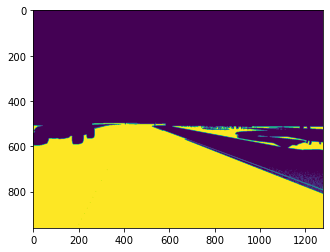

In [109]:
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

Nous fournissons également une fonction pour visualiser l'espace de conduite estimé en 3D. Exécutez la cellule suivante pour visualiser votre espace de conduite estimé en 3D.

/home/jovyan/va/TP_va/m6bk.py:226: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/home/jovyan/va/TP_va/m6bk.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


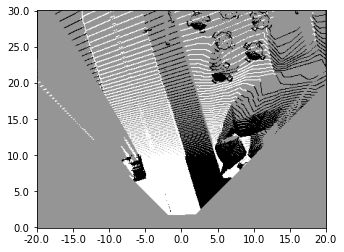

In [110]:
dataset_handler.plot_free_space(ground_mask)

La visualisation ci-dessus montre uniquement où la voiture autonome peut se déplacer physiquement. Les obstacles tels que le SUV à gauche de l'image sont visibles sous forme de pixels sombres dans notre visualisation :

<tr>
<td> <img src="images/image.png" style="width:320px;height:240px;">   </td>
<td> <img src="images/occ_grid.png" style="width:240px;height:240px;">   </td>
</tr>

Cependant, estimer l'espace de conduite ne suffit pas pour que la voiture autonome puisse circuler sur les routes. La voiture autonome doit encore effectuer une estimation de voie pour savoir où elle est autorisée à conduire légalement. Une fois que vous êtes à l'aise avec l'estimation de l'espace de conduite, poursuivez l'évaluation pour estimer la voie où la voiture peut circuler.

## 2 - Estimation des voies en utilisant la sortie de la segmentation sémantique


Votre deuxième tâche pour cette évaluation consiste à utiliser la sortie de la segmentation sémantique pour estimer les limites de voie de la voie actuelle utilisée par la voiture autonome.

 Cette tâche peut être divisée en deux sous-tâches : l'estimation des lignes de voie et le post-traitement à travers le filtrage des lignes horizontales et la fusion des lignes similaires.

### 2.1 Estimating Lane Boundary Proposals:

La première étape pour effectuer cette tâche consiste à estimer toute ligne qui peut être considérée comme une limite de voie en utilisant la sortie de la segmentation sémantique. Nous appelons ces lignes des "propositions".

**Exercise**: 
Estimez les propositions de lignes de voie en utilisant les fonctions OpenCV. Voici les 3 étapes :

Créez une image contenant les pixels de segmentation sémantique appartenant aux catégories pertinentes pour les limites de voie, de manière similaire à ce que nous avons fait précédemment pour le plan de la route. Pour cette évaluation, ces pixels ont la valeur 6 et 8 dans la sortie de segmentation du réseau neuronal.
Effectuez une détection de contours sur l'image dérivée des limites de voie.
Effectuez une estimation de ligne sur la sortie de la détection de contours.

Useful functions: `cv2.Canny()`, `cv2.HoughLinesP()`, `np.squeeze()`.

In [ ]:
# GRADED FUNCTION: estimate_lane_lines
def estimate_lane_lines(segmentation_output):
    """
    Estime les lignes appartenant aux limites des voies. Plusieurs lignes peuvent correspondre à une seule voie.

    Arguments:
    segmentation_output -- tenseur de dimension (H, W), contenant la sortie du réseau neuronal de segmentation sémantique
    minLineLength -- scalaire, la longueur minimale de ligne
    maxLineGap -- scalaire, l'écart maximal entre les lignes

    Renvoie:
    lines -- tenseur de dimension (N, 4) contenant les lignes sous la forme [x_1, y_1, x_2, y_2], où [x_1, y_1] et [x_2, y_2] sont
    les coordonnées de deux points sur la ligne dans le système de coordonnées d'image (u,v).
    """

    ### DÉBUTEZ LE CODE ICI ### (≈ 7 lignes au total)
    # Étape 1: Créez une image avec les pixels appartenant aux catégories de limites de voie à partir de la sortie de la segmentation sémantique


    # Étape 2: Effectuez une détection de contour en utilisant cv2.Canny()


    # Étape 3: Estimez les lignes en utilisant cv2.HoughLinesP()


    # Note : Assurez-vous que les dimensions des lignes renvoyées sont (N x 4)
    ### FIN DU CODE ICI ###


    return lines

(14, 4)


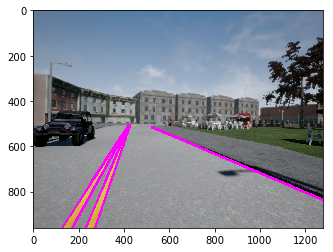

In [ ]:
lane_lines = estimate_lane_lines(segmentation)

print(lane_lines.shape)

plt.imshow(dataset_handler.vis_lanes(lane_lines))

***Expected Output***

<img src="images/lanes_1.png" style="width:320px;height:240px;"> 

### 2.2 - Fusion et filtrage des lignes de voie:

La deuxième sous-tâche pour estimer la limite de voie actuelle consiste à fusionner les lignes redondantes et à filtrer les lignes horizontales apparentes dans l'image. La fusion des lignes redondantes peut être résolue en regroupant les lignes ayant une pente et une ordonnée à l'origine similaires. Les lignes horizontales peuvent être filtrées en utilisant un seuil de pente.

**Exercise**: 

Post-traitez la sortie de la fonction ``estimate_lane_lines`` pour fusionner les lignes similaires et filtrer les lignes horizontales en utilisant la pente et l'ordonnée à l'origine. Les trois étapes sont les suivantes :
1. Obtenez la pente et l'ordonnée à l'origine de chaque ligne en utilisant la fonction fournie.
2. Identifiez les lignes ayant une pente inférieure au seuil de pente horizontal. Le filtrage peut être effectué ultérieurement si nécessaire.
3. Regroupez les lignes en clusters en fonction de leur pente et de leur ordonnée à l'origine

4. Fusionnez toutes les lignes dans les clusters en utilisant la moyenne.








Usefull Functions:
1. ***get_slope_intecept(lines):***

```
  Calcule la distance entre N points et un plan en 3D, étant donné les paramètres du plan et les coordonnées x,y,z des points.

  Arguments : lines -- tenseur de dimension (N,4) contenant les lignes sous la forme [x_1, y_1, x_2, y_2], les coordonnées de deux points sur la ligne.

  Renvoie :
  slopes -- tenseur de dimension (N,1) contenant les pentes des lignes.
  intercepts -- tenseur de dimension (N,1) contenant les ordonnées à l'origine des lignes.

```

Cette fonction est déjà chargée grâce à l'instruction d'importation au début du notebook. Vous pouvez également effectuer vous-même l'estimation du plan si vous êtes prêt à relever le défi !

In [ ]:
# Graded Function: merge_lane_lines
def merge_lane_lines(
        lines):
    """
    Fusionne les lignes de voie pour produire une seule ligne par voie, en utilisant la pente et l'ordonnée à l'origine comme mesures de similarité.
    Filtre également les lignes de voie horizontales en fonction d'un seuil de pente minimum.

    Arguments :
    lines -- tenseur de dimension (N, 4) contenant des lignes sous la forme [x_1, y_1, x_2, y_2],
    les coordonnées de deux points sur la ligne.

    Renvoie :
    merged_lines -- tenseur de dimension (N, 4) contenant des lignes sous la forme [x_1, y_1, x_2, y_2],
    les coordonnées de deux points sur la ligne.
    """
    
    ### START CODE HERE ### (≈ 25 lines in total)
    
    # Step 0: Define thresholds
    slope_similarity_threshold = 0.1
    intercept_similarity_threshold = 40
    min_slope_threshold = 0.3
    
    # Step 1: Get slope and intercept of lines
    slopes, intercepts = get_slope_intecept(lines)
    
    # Step 2: Determine lines with slope less than horizontal slope threshold.

    # Step 3: Iterate over all remaining slopes and intercepts and cluster lines that are close to each other using a slope and intercept threshold.
    for slope, intercept in zip(slopes, intercepts):
        

    # Step 4: Merge all lines in clusters using mean averaging

    
    # Note: Make sure dimensions of returned lines is (N x 4)
    ### END CODE HERE ###
    return merged_lines

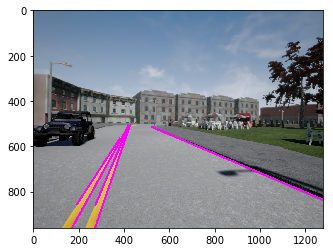

In [ ]:
merged_lane_lines = merge_lane_lines(lane_lines)

plt.imshow(dataset_handler.vis_lanes(merged_lane_lines))

***Expected Output***

<img src="images/lanes_2.png" style="width:320px;height:240px;"> 

Vous devriez maintenant avoir une ligne par voie en sortie ! La dernière étape consiste à extrapoler les voies pour qu'elles commencent au début de la route et se terminent à la fin de la route, et à déterminer les marquages de voie appartenant à la voie actuelle. Nous vous fournissons des fonctions qui effectuent ces tâches dans la cellule ci-dessous. Exécutez la cellule pour visualiser les limites finales des voies !

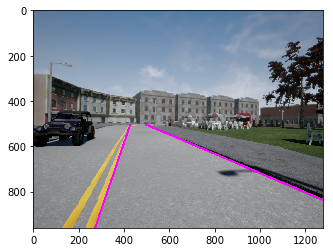

In [ ]:
max_y = dataset_handler.image.shape[0]
min_y = np.min(np.argwhere(road_mask == 1)[:, 0])

extrapolated_lanes = extrapolate_lines(merged_lane_lines, max_y, min_y)
final_lanes = find_closest_lines(extrapolated_lanes, dataset_handler.lane_midpoint)
plt.imshow(dataset_handler.vis_lanes(final_lanes))

## 3 -Calcul de la distance minimale d'impact en utilisant la sortie de la détection d'objets en 2D.

Votre dernière tâche pour cette évaluation consiste à utiliser la sortie de la détection d'objets en 2D pour déterminer la distance minimale d'impact avec les objets dans la scène.

 Cependant, la tâche est compliquée par le fait que les détections 2D fournies proviennent d'un détecteur d'objets 2D à rappel élevé et précision faible. Vous utiliserez d'abord la sortie de la segmentation sémantique pour déterminer quelles BB sont valides. Ensuite, vous calculerez la distance minimale d'impact en utilisant les BB restantes et l'image de profondeur. 
 
 Commençons par une visualisation de la détection de sortie pour notre image actuelle. Pour la visualisation, vous utiliserez la fonction de gestion des données fournies ``vis_object_detection`` de la manière suivante :

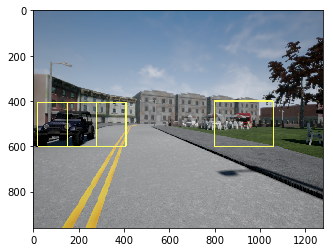

In [ ]:
detections = dataset_handler.object_detection

plt.imshow(dataset_handler.vis_object_detection(detections))

Les détections sont au format **[catégorie, x_min, y_min, x_max, y_max, score]**. La catégorie est une chaîne de caractères qui indique la classification de la boîte englobante, telle que 'Voiture', 'Piéton' ou 'Cycliste'. Les coordonnées **[x_min, y_min]** sont les coordonnées du coin supérieur gauche, et les coordonnées **[x_max, y_max]** sont les coordonnées du coin inférieur droit des objets. Le score représente la sortie du softmax du réseau neuronal.

In [ ]:
print(detections)

[['Car' '20.0' '406.0' '280.0' '599.0' '0.99']
 ['Car' '150.0' '406.0' '410.0' '599.0' '0.95']
 ['Car' '800.0' '400.0' '1060.0' '600.0' '0.76']]


### 3.1 - Filtrage des détections non fiables.

La première chose que vous pouvez remarquer est qu'une mauvaise détection se produit du côté droit de l'image. Ce qui est intéressant, c'est que cette mauvaise détection a un score de sortie élevé de 0,76 pour être une voiture. De plus, deux BB sont attribuées au véhicule à gauche de l'image, toutes deux avec un score très élevé, supérieur à 0,9. 

Ce comportement est attendu d'un détecteur d'objets à haute précision et faible rappel. Pour résoudre ce problème, la sortie du réseau de segmentation sémantique doit être utilisée pour éliminer les détections peu fiables.

**Exercise**: 
Éliminez les détections peu fiables en utilisant la sortie de la segmentation sémantique. Les trois étapes sont les suivantes :

1. Pour chaque détection, calculez combien de pixels dans la BB appartiennent à la catégorie prédite par le réseau neuronal.
2. Divisez le nombre de pixels calculé par la surface de la BB (nombre total de pixels).
3. Si le ratio est supérieur à un seuil, conservez la détection. Sinon, supprimez la détection de la liste des détections.
Usefull functions: ``np.asfarray()``

**Remarque** : Assurez-vous de traiter à la fois les catégories 'Voiture' et 'Piéton' dans le code.

In [ ]:
# Graded Function: filter_detections_by_segmentation
def filter_detections_by_segmentation(detections, segmentation_output):
    """
    Filtre la sortie de détection 2D en fonction d'une carte de segmentation sémantique.

    Arguments :

    detections : tenseur de dimension (N, 5) contenant les détections sous la forme [Classe, x_min, y_min, x_max, y_max, score].
    segmentation_output : tenseur de dimension (HxW) contenant les étiquettes de catégorie de pixels.
    
    Renvoie :

    filtered_detections : tenseur de dimension (N, 5) contenant les détections sous la forme [Classe, x_min, y_min, x_max, y_max, score].
    """
    ### START CODE HERE ### (≈ 20 lines in total)
    
    # Set ratio threshold:
    ratio_threshold = 0.3  # If 1/3 of the total pixels belong to the target category, the detection is correct.
    
    for detection in detections:
        
        # Étape 1 : Calculer le nombre de pixels appartenant à la catégorie pour chaque détection.
        
        # Étape 2 : Diviser le nombre de pixels calculé par la surface de la BB (nombre total de pixels).
            
        # Étape 3 : Si le ratio est supérieur à un seuil, conserver la détection. Sinon, supprimer la détection de la liste des détections.

 
    ### END CODE HERE ###
    
    return filtered_detections

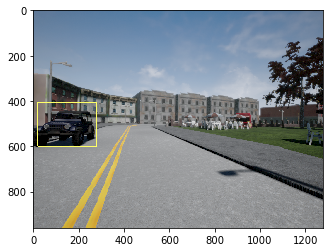

In [ ]:
filtered_detections = filter_detections_by_segmentation(detections, segmentation)

plt.imshow(dataset_handler.vis_object_detection(filtered_detections))

### 3.2 - Estimation de la distance minimale d'impact:

La tâche finale de cette évaluation consiste à estimer la distance minimale à chaque boîte englobante dans les détections d'entrée. Cela peut être réalisé en prenant simplement la distance minimale des pixels dans la boîte englobante au centre de la caméra.

**Exercise**: Calculez la distance minimale d'impact entre chaque objet restant après le filtrage et la voiture autonome. Les deux étapes sont les suivantes :

1. Calculez la distance jusqu'au centre de la caméra en utilisant les tableaux x, y et z de la partie I. Cela peut être fait selon l'équation : $ distance = \sqrt{x^2 + y^2 + z^2}$.
2. Trouvez la valeur de la distance minimale parmi tous les pixels à l'intérieur de la boîte englobante.



In [ ]:
# Graded Function: find_min_distance_to_detection:
def find_min_distance_to_detection(detections, x, y, z):
    """

    Filtre la sortie de détection 2D en fonction d'une carte de segmentation sémantique.

    Arguments :

    detections : tenseur de dimension (N, 5) contenant les détections sous la forme [Classe, x_min, y_min, x_max, y_max, score].
    x : tenseur de dimension (H, W) contenant les coordonnées x de chaque pixel dans le cadre de référence de la caméra.
    y : tenseur de dimension (H, W) contenant les coordonnées y de chaque pixel dans le cadre de référence de la caméra.
    z : tenseur de dimensions (H, W) contenant les coordonnées z de chaque pixel dans le cadre de référence de la caméra.
    
    Renvoie :

    min_distances : tenseur de dimension (N, 1) contenant la distance minimale d'impact avec chaque objet dans la scène.

    """
    ### START CODE HERE ### (≈ 20 lines in total)

    for detection in detections:
        # Step 1: Compute distance of every pixel in the detection bounds
        
        # Step 2: Find minimum distance

    ### END CODE HERE ###
    return min_distances

In [ ]:
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)

print('Minimum distance to impact is: ' + str(min_distances))


Minimum distance to impact is: [8.517358087690415]


**Expected Output**

Minimum distance to impact is: 8.51




Exécutez la cellule ci-dessous pour visualiser votre distance estimée ainsi que la sortie de détection 2D.

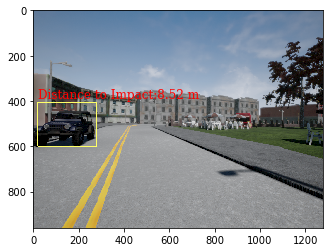

In [ ]:
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}

im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asfarray(detection[1:5])
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)

## 4 - Submission:
L'évaluation de toutes les fonctions sera basée sur trois sorties pour la première image de l'ensemble de données :

1. Le plancher estimé à partir de la partie 1.
2. Les voies estimées à partir de la partie 2.
3. Les distances estimées à partir de la partie 3.
Veuillez exécuter la cellule ci-dessous, puis copier sa sortie dans le fichier output.yaml fourni pour soumission sur la page de l'assignation de programmation.


In [ ]:
dataset_handler = DatasetHandler()
dataset_handler.set_frame(1)
segmentation = dataset_handler.segmentation
detections = dataset_handler.object_detection
z = dataset_handler.depth

# Part 1
k = dataset_handler.k
x, y = xy_from_depth(z, k)
road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = dataset_handler.depth[road_mask == 1]
xyz_ground = np.stack((x_ground, y_ground, z_ground))
p_final = ransac_plane_fit(xyz_ground)

# Part II
lane_lines = estimate_lane_lines(segmentation)
merged_lane_lines = merge_lane_lines(lane_lines)
max_y = dataset_handler.image.shape[0]
min_y = np.min(np.argwhere(road_mask == 1)[:, 0])

extrapolated_lanes = extrapolate_lines(merged_lane_lines, max_y, min_y)
final_lanes = find_closest_lines(extrapolated_lanes, dataset_handler.lane_midpoint)

# Part III
filtered_detections = filter_detections_by_segmentation(detections, segmentation)
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)

# Print Submission Info

final_lane_printed = [list(np.round(lane)) for lane in final_lanes]
print('plane:') 
print(list(np.round(p_final, 2)))
print('\n lanes:')
print(final_lane_printed)
print('\n min_distance')
print(list(np.round(min_distances, 2)))


plane:
[-0.0, 1.0, 0.02, -1.35]

 lanes:
[[1564.0, 960.0, 669.0, 484.0], [190.0, 960.0, 619.0, 484.0]]

 min_distance
[7.01, 9.9]


### Visualize your Results:

Assurez-vous que la visualisation de vos résultats est attrayante avant de soumettre vos résultats.

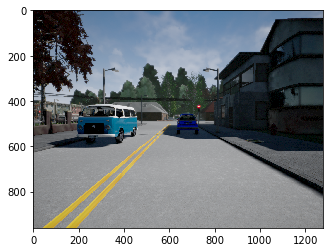

In [ ]:
# Original Image
plt.imshow(dataset_handler.image)

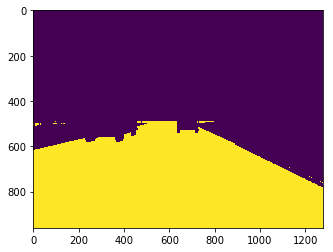

In [ ]:
# Part I
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

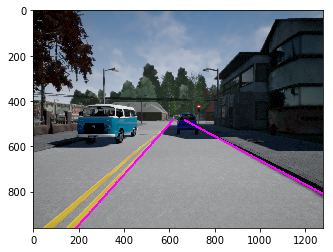

In [ ]:
# Part II
plt.imshow(dataset_handler.vis_lanes(final_lanes))

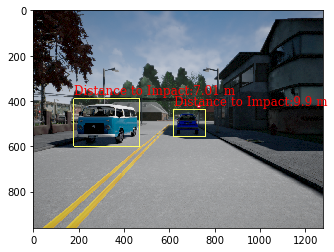

In [ ]:
# Part III
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}

im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asfarray(detection[1:5])
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)

<font color='blue'>
**What you should remember**:
- La sortie de la segmentation sémantique peut être utilisée pour estimer l'espace praticable.
- La vision par ordinateur classique peut être utilisée pour trouver les limites des voies.
- La sortie de la segmentation sémantique peut être utilisée pour filtrer les sorties non fiables de la détection d'objets.

Félicitations pour avoir terminé le tp !




